In [1]:
import seagul.envs
import gym

import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import torch

from itertools import product
from multiprocessing import Pool
import time
from seagul.integration import rk4

import gym
import seagul.envs
from numpy import pi, sin, cos
import time
import matplotlib.pyplot as plt
from control import lqr, ctrb

from seagul.rl.models import PPOModelActHold
from seagul.nn import MLP
from seagul.rl.run_utils import load_workspace

from scipy.integrate import solve_ivp

#m1=1; m2=1; l1=1; l2=1; lc1=.5; lc2=.5; I1=.2; I2=1.0; g=9.8;
m1=1; m2=1; l1=1; l2=2; lc1=.5; lc2=1; I1=.083; I2=.33; g=9.8;


th1 = pi/2; th2 = 0; th1d = 0; th2d = 0;

TAU = np.array([[0],[1]])

m11 = m1*lc1**2 + m2*(l1**2 + lc2**2 + 2*l1*lc2*cos(th2)) + I1 + I2;
m22 = m2*lc2**2 + I2;
m12 = m2*(lc2**2 + l1*lc2*cos(th2)) + I2;
M = np.array([[m11, m12], [m12, m22]]);

h1 = -m2*l1*lc2*sin(th2)*th2d**2 - 2*m2*l1*lc2*sin(th2)*th2d*th1d;
h2 = m2*l1*lc2*sin(th2)*th1d**2;
H = np.array([[h1],[h2]]);

phi1 = (m1*lc1+m2*l1)*g*cos(th1) + m2*lc2*g*cos(th1+th2);
phi2 = m2*lc2*g*cos(th1+th2);
PHI = np.array([[phi1], [phi2]])

Bl = np.linalg.inv(M)@TAU
Blin = np.array([[0, 0],[0, 0],[0, Bl[0].item()], [0, Bl[1].item()]])

DPHI = np.array([[-g*(m1*lc1 + m2*l1 + m2*lc2), -m2*lc2*g], [-m2*lc2*g, -m2*lc2*g]])
Al = -np.linalg.inv(M)@DPHI
Alin = np.array([[0,0, 1, 0],[0, 0, 0, 1], [Al[0,0], Al[0,1],0,0], [Al[1,0], Al[1,1], 0, 0]])

#print("M: \n", M)
#print("Tau: \n", TAU)
#print("H: \n", -H)
#print("PHI: \n", -PHI)
#print("Blin \n", B )

Ctr = ctrb(Alin, Blin)
assert np.linalg.matrix_rank(Ctr) == 4

Q = np.identity(4)
#Q[0,0] = 1
#Q[1,1] = 1
#Q[2,2] = 1
#Q[3,3] = 1

#Q = np.array([[1000, -500, 0,0],[-500, 1000, 0, 0],[0, 0, 1000, -500],[0,0,-500,1000]])

R = np.identity(2)*.5
K,S,E = lqr(Alin,Blin,Q,R)
k = np.array(K[1,:])
print(k)

[[-260.26043439 -104.29824982 -112.479077    -52.88147775]]


total 0.04930567741394043
[1500.]


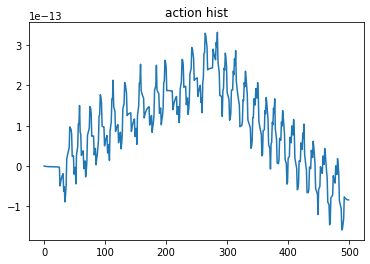

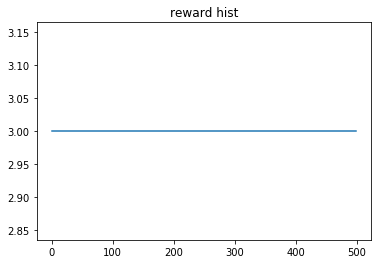

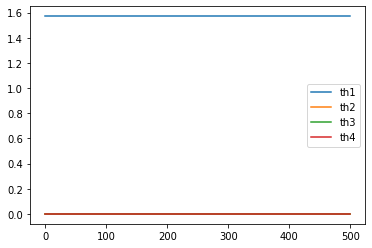

In [27]:
max_torque = 25

def reward_fn(s,a):
    reward = np.sin(s[0]) + 2*np.sin(s[0] + s[1])
    done = reward < 0
    
    return reward, done

config = {"init_state" : [0,0,0,0], 
          "max_torque" : max_torque, 
          "init_state_weights" : [0,0,0,0], 
          "dt" : .01,
          "m2" : m2,
          "m1" : m1,
          "l1" : l1,
          "lc1" : lc1,
          "lc2" : lc2,
          "i1" : I1,
          "i2" : I2,
          "reward_fn" : reward_fn
        }

env = gym.make('su_acrobot-v0', **config)

env.num_steps = 500

def control(q):
    #import ipdb; ipdb.set_trace()
    gs = np.array([pi/2,0,0,0])
    #return 0
    return -k.dot(q - gs)


action_hist = np.zeros((env.num_steps,1))
action2_hist = np.zeros((env.num_steps,1))

state_hist = np.zeros((env.num_steps, env.observation_space.shape[0]))
reward_hist = np.zeros((env.num_steps, 1))
obs = env.reset(init_vec =[pi/2,0,0,0]) 

import time
start = time.time()
for i in range(env.num_steps):
        actions = np.clip(np.asarray(control(obs)), -max_torque, max_torque)
        #actions = np.array([0])
        #env.render()
        #obs = torch.as_tensor(obs, dtype=torch.float32)
        #actions = np.clip(np.asarray(pol(obs).detach()),-max_torque, max_torque)
        
        obs, reward, done, _ = env.step(actions)
        action_hist[i,:] = np.copy(actions)
        state_hist[i,:] = np.copy(obs)
        reward_hist[i,:] = np.copy(reward)
       # if done:
       #     break
            
print("total", time.time() - start)

plt.plot(action_hist)
plt.title('action hist')

plt.figure()
plt.plot(reward_hist)
plt.title('reward hist')

plt.figure()
plt.plot(state_hist)
plt.legend(['th1', 'th2', 'th3', 'th4'])


print(sum(reward_hist))

5.305976629257202


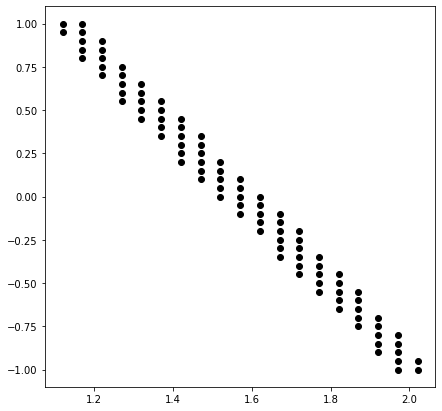

In [14]:
env = gym.make('su_acrobot-v0', **config)
env.num_steps = 500

action_hist = np.zeros((env.num_steps,1))
state_hist = np.zeros((env.num_steps, env.observation_space.shape[0]))
reward_hist = np.zeros((env.num_steps, 1))

th1_min = pi/2-1; th1_max = pi/2+1; num_th1 = 41 
th1_vals = np.linspace(th1_min, th1_max, num_th1)

th2_min = -1; th2_max = 1; num_th2 = 41
th2_vals = np.linspace(th2_min, th2_max, num_th2)

results = np.zeros((th1_vals.size, th2_vals.size))
rewards = np.zeros((th1_vals.size, th2_vals.size))

import time
start = time.time()

def do_rollout(th):
    th1,th2 = th
    obs = env.reset(init_vec = [th1, th2, 0, 0])
    reward_hist = []
    for i in range(env.num_steps):
        actions = np.clip(np.asarray(control(obs)), -max_torque, max_torque)
        obs, reward, done, _ = env.step(actions)
        reward_hist.append(np.copy(reward))
        
    return sum(reward_hist)

pool = Pool() #defaults to number of available CPU's
for ind, res in enumerate(pool.imap(do_rollout, product(th1_vals, th2_vals)),1):
        results.flat[ind-1] = res > env.num_steps*3-50
        rewards.flat[ind-1] = res
       
end = time.time()
print(end - start)


plt.figure(figsize=(7,7))
for i,ival in enumerate(results[:,:]):
    for j,val in enumerate(ival):
            #plt.plot(th1_vals[i], slope*(th1_vals[i]-pi), 'o', color='blue')

            if val:
                plt.plot(th1_vals[i], th2_vals[j], 'o', color = 'black')
            #else:
            #    plt.plot(th1_vals[i], th2_vals[j], 'o', color='black')

In [32]:
env = gym.make('su_acrobot-v0',**config)
env.num_steps = 500

action_hist = np.zeros((env.num_steps,1))
state_hist = np.zeros((env.num_steps, env.observation_space.shape[0]))
reward_hist = np.zeros((env.num_steps, 1))

th1dot_min = -5; th1dot_max = 5; num_th1dot = 81
th1dot_vals = np.linspace(th1dot_min, th1dot_max, num_th1dot)

th2dot_min = -10; th2dot_max = 10; num_th2dot = 81
th2dot_vals = np.linspace(th2dot_min, th2dot_max, num_th2dot)

results = np.zeros((th1dot_vals.size, th2dot_vals.size))
rewards = np.zeros((th1dot_vals.size, th2dot_vals.size))

import time
start = time.time()

def do_rollout(th):
    dth1,dth2 = th
    obs = env.reset(init_vec = ([pi/2, 0, dth1, dth2]))
    reward_hist = []
    for i in range(env.num_steps):
        actions = np.clip(np.asarray(control(obs)), -max_torque, max_torque)
        obs, reward, done, _ = env.step(actions)
        reward_hist.append(np.copy(reward))
        
    return sum(reward_hist)

pool = Pool() #defaults to number of available CPU's
for ind, res in enumerate(pool.imap(do_rollout, product(th1dot_vals, th2dot_vals)),1):
        results.flat[ind-1] = res > env.num_steps*3-10
        rewards.flat[ind-1] = res
       
end = time.time()
print(end - start)


                                
plt.figure(figsize=(7,7))
                               
for i,ival in enumerate(results[:,:]):
    for j,val in enumerate(ival):
            if val:
                plt.plot(th1dot_vals[i], th2dot_vals[j], 'o', color = 'black')

177.77776050567627


<Figure size 504x504 with 0 Axes>

In [ ]:
import pickle
pickle.dump(X, open('./warm/X_zv_128', 'wb'))
pickle.dump(Y, open('./warm/Y_zv_128', 'wb'))

In [ ]:
from seagul.nn import MLP
pol = MLP(4,1,0,0,input_bias = True)
d = pol.state_dict()
d['output_layer.weight'] = torch.tensor([[1316.85, 555.42, 570.33, 272.58]], dtype=torch.float32)
d['output_layer.bias'] = torch.tensor([0.0],dtype=torch.float32)
d['input_bias'] = torch.tensor([-np.pi, 0.0, 0.0, 0.0], dtype=torch.float32)
pol.load_state_dict(d)
torch.save(pol, 'warm/LQR_policy')

In [65]:
good_list = []

config = {"init_state" : [0,0,0,0], 
          "max_torque" : max_torque, 
          "init_state_weights" : [0,0,0,0], 
          "dt" : .01,
          "m2" : m2,
          "m1" : m1,
          "l1" : l1,
          "lc1" : lc1,
          "lc2" : lc2,
          "i1" : I1,
          "i2" : I2,
          "reward_fn" : reward_fn,
          "act_hold" : 1
        }

env = gym.make('su_acrobot-v0', **config)

num_trials = 1000
action_hist = np.zeros((num_trials, env.num_steps,1))
state_hist = np.zeros((num_trials, env.num_steps, env.observation_space.shape[0]))
reward_hist = np.zeros((num_trials, env.num_steps, 1))
gate_hist = np.zeros((num_trials, env.num_steps,1))
good_list = []

act_hold = 20
hold_count = 0
obs = env.reset()

rewards = np.zeros((th1dot_vals.size, th2dot_vals.size))

import time
start = time.time()

def do_rollout(trial_num):
    np.random.seed(trial_num)
    act_hold = 20
    hold_count = 0
    obs = env.reset()
    local_good = False
    actions = np.random.randn(1)*3

    local_state_hist = np.zeros((env.num_steps, env.observation_space.shape[0]))
    local_reward_hist = np.zeros((env.num_steps, 1))
    local_gate_hist = np.zeros((env.num_steps,1))
    local_action_hist = np.zeros((env.num_steps,1))
    

    for i in range(env.num_steps):
        if abs(obs[0] - np.pi/2) < .2 and abs(obs[1]) < .2 and abs(obs[2]) < 3 and abs(obs[3]) < 3:
            actions = np.clip(np.asarray(control(obs)), -max_torque, max_torque)
            local_good = True
            local_gate_hist[i] = 1
        else:
            local_gate_hist[i] = 0
            if hold_count == act_hold:
                actions = np.random.randn(1)*3
                hold_count = 0
        
        hold_count+=1
        obs, reward, done, _ = env.step(actions)   
        local_action_hist[i,:] = np.copy(actions)
        local_state_hist[i,:] = np.copy(obs)
        local_reward_hist[i,:] = np.copy(reward)
    
    return local_action_hist, local_state_hist, local_reward_hist, local_gate_hist, local_good

pool = Pool() #defaults to number of available CPU's
for ind, res in enumerate(pool.imap(do_rollout,range(num_trials))):
        acts, obs, rews, gate, good = res
        action_hist[ind, :,:] = acts
        state_hist[ind, :,:] = obs
        reward_hist[ind, :,:] = rews
        gate_hist[ind, :,:] = gate
        if good:
            good_list.append(ind)
            


print(time.time() - start)

            

2.8866965770721436


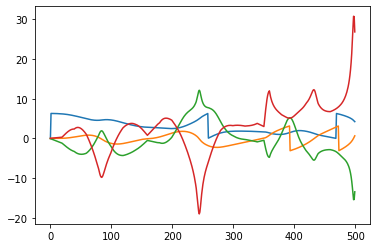

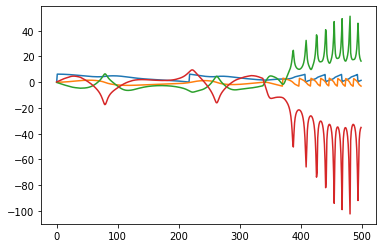

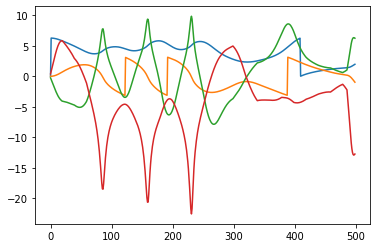

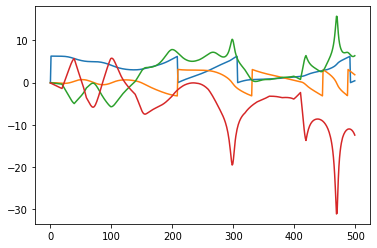

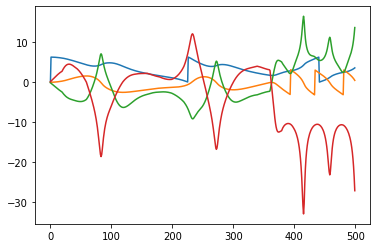

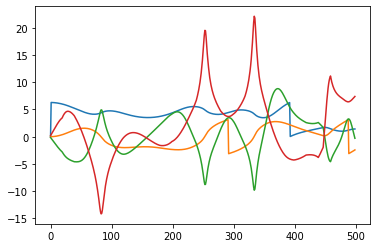

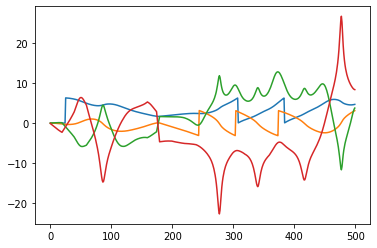

<Figure size 432x288 with 0 Axes>

In [66]:
for trial in good_list:
    plt.plot(state_hist[trial,:,:])
    plt.figure()
